# Sieć Neuronowa
Łukasz Klimkiewicz, 244822

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [2]:
# Numer indeksu
index = 244822

# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


### Funkcje aktywacji

In [3]:
class Activation:
    
    def call(self, x):
        raise NotImplementedError('call function is not implemented')
    
    def deriv(self, x):
        raise NotImplementedError('deriv function is not implemented')

In [136]:
class NoActivation(Activation):
    
    def call(self, x):
        return x.copy()
    
    def deriv(self, x):
        return np.ones_like(x)

In [104]:
from scipy.special import expit

class LogisticActivation(Activation):
    
    def call(self, x):
        return expit(x)
    
    def deriv(self, x):
        y = self.call(x)
        return y * (1-y)

In [6]:
class ReLuActivation(Activation):
    
    def call(self, x):
        return np.maximum(x, 0)
    
    def deriv(self, x):
        return (x > 0).astype(np.float32)

In [7]:
class LeakyReLuActivation(Activation):
    
    def __init__(self, coef=0.01):
        self.coef = coef
    
    def call(self, x):
        return np.where(x > 0, x, self.coef*x)
    
    def deriv(self, x):
        return np.where(x > 0, 1, self.coef)

In [8]:
class TanhActivation(Activation):
    
    def call(self, x):
        return np.tanh(x)
    
    def deriv(self, x):
        return 1 - np.tanh(x) ** 2

In [9]:
class SinActivation(Activation):
    
    def call(self, x):
        return np.sin(x)
    
    def deriv(self, x):
        return np.cos(x)

### Warstwy sieci

In [10]:
class Layer:
    
    def __init__(self, neurons):
        self.neurons = neurons
        self.nn = None
        self.prev_layer = None
        self.next_layer = None

    def connect(self, nn, prev_layer, next_layer):
        self.nn = nn
        self.prev_layer = prev_layer
        self.next_layer = next_layer

    def propagate(self, x):
        raise NotImplementedError('propagate method not implemented')

    def backpropagate(self, delta):
        raise NotImplementedError('backpropagate method not implemented')

In [11]:
class InputLayer(Layer):

    def __init__(self, neurons):
        super().__init__(neurons)

    def propagate(self, x):
        return self.next_layer.propagate(x) if self.next_layer else x

    def backpropagate(self, delta):
        pass

In [44]:
class DenseLayer(Layer):

    def __init__(self, neurons, activation: Activation, weights_scale=1):
        super().__init__(neurons)
        self.activation = activation
        self.weights_scale = 1
        
        self.weights = None
        self.input_ = None
        self.state = None
        
    def connect(self, nn, prev_layer, next_layer):
        super().connect(nn, prev_layer, next_layer)
        self.weights = self.weights_scale * np.random.rand(self.neurons, prev_layer.neurons)

    def propagate(self, x):
        state = x @ self.weights.T
        output = self.activation.call(state)
        
        self.input_ = x
        self.state = state.reshape(-1, 1)
        
        return self.next_layer.propagate(output) if self.next_layer else output

    def backpropagate(self, delta):
        self._adjust_weights(delta)
        if self.prev_layer:
            next_delta = self._get_next_delta(delta)
            self.prev_layer.backpropagate(next_delta)
            
    def _adjust_weights(self, delta):
        weights_delta = self.nn.learning_rate * delta.T * self.activation.deriv(self.state) @ self.input_
        self.weights += weights_delta
        
    def _get_next_delta(self, delta):
        deriv = self.activation.deriv(self.state.T)
        delta_deriv = delta * deriv
        next_delta = delta_deriv @ self.weights
        return next_delta

### Sieć neuronowa

In [85]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NeuralNetwork(BaseEstimator, ClassifierMixin):

    def __init__(self, layers, epochs=10, learning_rate=0.1, seed=None):
        self._connect(layers)
        self.layers = layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.seed = seed
        
    def _connect(self, layers):
        for i in range(len(layers)):
            layer = layers[i]
            prev_layer = layers[i-1] if i-1 >= 0 else None
            next_layer = layers[i+1] if i+1 < len(layers) else None
            layer.connect(self, prev_layer, next_layer)
        
    @property
    def input_layer(self):
        return self.layers[0]
    
    @property
    def output_layer(self):
        return self.layers[-1]
    
    def fit(self, X, Y):
        if self.seed:
            np.random.seed(self.seed)
        
        for i in range(self.epochs):
            self._learn_epoch(X, Y)
    
    def _learn_epoch(self, X, Y):
        for x, y in zip(X, Y):
            self._learn_single(x.reshape(1, -1), y.reshape(1, -1))
    
    def _learn_single(self, x, y):
        prediction = self.input_layer.propagate(x)
        delta = y - prediction
        self.output_layer.backpropagate(delta)
    
    def predict(self, X):
        return self.input_layer.propagate(X)

In [62]:
from sklearn.preprocessing import OneHotEncoder

class BinaryNNClassifier(NeuralNetwork):

    def __init__(self, layers, epochs=10, learning_rate=0.1, seed=None):
        super().__init__(layers, epochs, learning_rate, seed)
        self.encoder = OneHotEncoder()
    
    def predict(self, X):
        output = self.input_layer.propagate(X)
        assert output.shape[1] == 1
        output = output.flatten()
        labels = (output > 0.5).astype(np.int_)
        return labels
    
    def predict_proba(self, X):
        output = self.input_layer.propagate(X)
        output = output.flatten()
        nom = np.exp(output)
        denom = np.sum(nom)
        return nom / denom

In [45]:
from sklearn.preprocessing import OneHotEncoder

class MulticlassNNClassifier(NeuralNetwork):

    def __init__(self, layers, epochs=10, learning_rate=0.1, seed=None):
        super().__init__(layers, epochs, learning_rate, seed)
        self.encoder = OneHotEncoder()

    def fit(self, X, Y):
        encoded_Y = self.encoder.fit_transform(Y.reshape(-1, 1)).toarray()
        super().fit(X, encoded_Y)
    
    def predict(self, X):
        output = self.input_layer.propagate(X)
        labels_no = np.argmax(output, axis=1)
        labels = np.take(self.encoder.categories_, labels_no)
        return labels

## Funkcje pomocnicze

In [24]:
def plot_classifier(classifier, data, *, ax, margin=0.2, resolution=100, 
                    title='Powierzchnia decyzyjna', xl='Cecha 1', yl='Cecha 2'):

    x1 = data['x'][:,0].min() - margin
    x2 = data['x'][:,0].max() + margin
    y1 = data['x'][:,1].min() - margin
    y2 = data['x'][:,1].max() + margin

    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = classifier.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title);
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

In [58]:
from sklearn.metrics import recall_score, f1_score, accuracy_score

def show_models_metrics(models, data):
    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)
    acc = accuracy_score(data['y'], predictions)

    print(f'Sensitivity: {sens:.2f}')
    print(f'Specificity: {spec:.2f}')
    print(f'F1: {f1:.2f}')
    print(f'Accuracy: {acc:.2f}')

In [68]:
from sklearn.metrics import RocCurveDisplay

def show_roc_curves(model, data):
    fig, ax = plt.subplots(figsize=(11, 4))
    
    predictions = model.predict_proba(data['x'])
    RocCurveDisplay.from_predictions(data['y'], predictions, ax=ax)
    ax.grid()
        
    ax.set_title('ROC')
    fig.tight_layout()

In [73]:
import timeit

def measure_times(model, data, n_fit, n_predict):

    def time_fit():
        model.fit(data['train']['x'], data['train']['y'])

    def time_predict():
        model.predict(data['test']['x'])

    fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
    predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

    print(f'Fit time {fit_time:.6f}')
    print(f'predict time {predict_time:.6f}')

## Zbiór syntetyczny

### Generowanie danych

In [25]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn_x, syn_y = make_classification(n_samples=n_samples, n_features=4, n_informative=4, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=5, random_state=seed,
                                     class_sep=13, hypercube=False)

syn_x = syn_x[:, :2]

# Podział na zbiory
syn_train_x, syn_test_x, syn_train_y, syn_test_y = train_test_split(
    syn_x, syn_y, test_size=.2, random_state=seed, stratify=syn_y)

# Strukturyzacja
syn_data = {
    'train': {
        'x': syn_train_x,
        'y': syn_train_y
    },
    'test': {
        'x': syn_test_x,
        'y': syn_test_y
    }
}

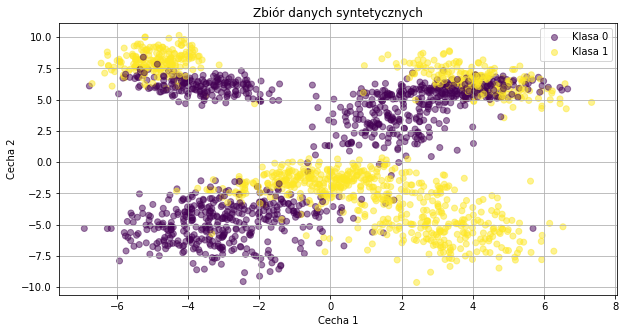

In [26]:
# Wyświetlanie
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
scatter = ax.scatter(syn_data['train']['x'][:,0], syn_data['train']['x'][:,1], c=syn_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.set_title('Zbiór danych syntetycznych')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()

### Nauka

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from time import time

layers = [
    InputLayer(2),
    DenseLayer(5, LogisticActivation(), weights_scale=0.1),
    DenseLayer(5, LogisticActivation(), weights_scale=0.1),
    DenseLayer(1, LogisticActivation(), weights_scale=0.1),
]

syn_model = make_pipeline(
    MinMaxScaler((-1, 1)),
    BinaryNNClassifier(layers, epochs=200, learning_rate=0.1)
)

start = time()
syn_model.fit(syn_data['train']['x'], syn_data['train']['y']);
print(f'Fit time: {time() - start:.2f}s')

Fit time: 26.33s


### Wyniki

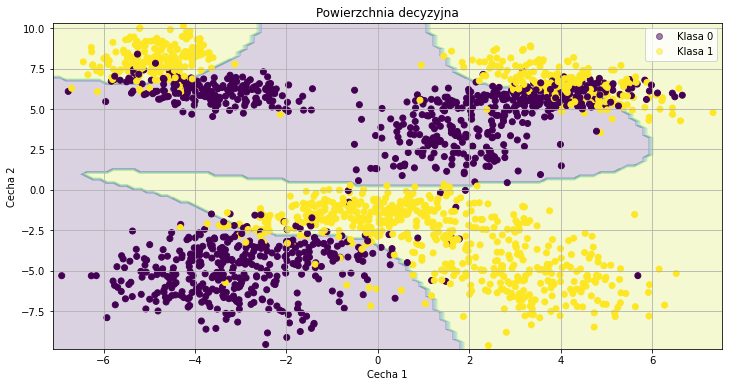

In [65]:
predictions = syn_model.predict(syn_data['test']['x'])
fig, ax = plt.subplots(figsize=(12, 6))
plot_classifier(syn_model, syn_data['train'], ax=ax)

In [66]:
show_models_metrics(syn_model, syn_data['test'])

Sensitivity: 0.88
Specificity: 0.90
F1: 0.89
Accuracy: 0.89


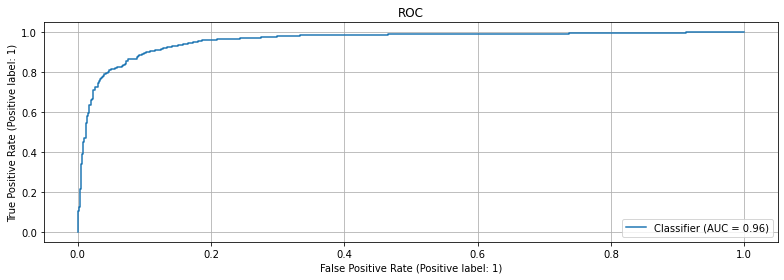

In [69]:
show_roc_curves(syn_model, syn_data['train'])

In [74]:
measure_times(syn_model, syn_data, n_fit=2, n_predict=20)

Fit time 26.574911
predict time 0.000146


## Zbiór MNIST

### Wczytywanie danych

In [75]:
def read_labels(filename):
    labels = []
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        assert magic == 2049
        size = int.from_bytes(f.read(4), 'big')
        for i in range(size):
            label = int.from_bytes(f.read(1), 'big')
            labels.append(label)
    return np.array(labels)


def read_images(filename):
    images = []
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        assert magic == 2051
        size = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        columns = int.from_bytes(f.read(4), 'big')
        for image_no in range(size):
            data = f.read(columns*rows)
            image = np.array(list(data), dtype=np.float64)
            image /= 256
            image -= 0.5
            images.append(image)
    return np.array(images)

In [76]:
train_images = read_images('data/train-images.idx3-ubyte')
train_labels = read_labels('data/train-labels.idx1-ubyte')
test_images = read_images('data/t10k-images.idx3-ubyte')
test_labels = read_labels('data/t10k-labels.idx1-ubyte')

In [77]:
# Strukturyzacja
mnist_data = {
    'train': {
        'x': train_images,
        'y': train_labels
    },
    'test': {
        'x': test_images,
        'y': test_labels
    }
}

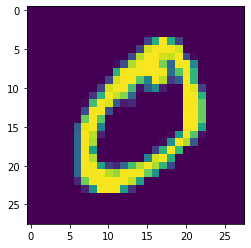

In [78]:
# Przykładowy obraz
from matplotlib.pyplot import imshow
imshow(mnist_data['train']['x'][1].reshape(28, 28));

### Nauka

In [137]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from time import time

layers = [
    InputLayer(784),
    DenseLayer(10, LeakyReLuActivation(), weights_scale=0.01),
    DenseLayer(10, LeakyReLuActivation(), weights_scale=0.01),
]

model = MulticlassNNClassifier(layers, epochs=40, learning_rate=0.01)

start = time()
model.fit(mnist_data['train']['x'], mnist_data['train']['y']);
print(f'Fit time: {time() - start:.2f}s')

Fit time: 146.24s


### Wyniki

In [138]:
from sklearn.metrics import classification_report

predictions = model.predict(mnist_data['test']['x'])
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
report = classification_report(mnist_data['test']['y'], predictions, target_names=names)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       980
           1       0.95      0.96      0.96      1135
           2       0.92      0.88      0.90      1032
           3       0.91      0.89      0.90      1010
           4       0.90      0.89      0.89       982
           5       0.96      0.76      0.85       892
           6       0.83      0.97      0.90       958
           7       0.97      0.86      0.91      1028
           8       0.74      0.93      0.83       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [92]:
measure_times(model, mnist_data, n_fit=1, n_predict=20)

Fit time 154.040402
predict time 0.005280
